In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from time import time
import copy

In [45]:
#handler function to make easier the choice's logic 
def activations(f):
        act = {
            'sigmoid': (lambda x: sigmoid(x), lambda x: d_sigmoid(x)),
            'tanh': (lambda x: tanh(x), lambda x: d_tanh(x)),
            'reLU': (lambda x: 0 if(x<0) else x, lambda x: 0 if(x<0) else 1)
        }
        return act[f]

#implementation of activation functions
#
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
#
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def d_tanh(x):
    return 1 - (tanh(x) * tanh(x))

In [46]:
#benchmark's purpose
class Timer:
    def __init__(self):
        pass
    
    def start(self):
        self.time = time()
    
    def stop(self):
        self.delta = time() - self.time
    
    def get(self):
        return self.delta

In [47]:
#Layer's attributes:
    #input - the input to the layer
    #net - the network input of the layer (dot product between input and weights)
    #out - the outuput of the layer(= f(net))

    #f - the activation function to use
    #d_f - the derivative of the activation function (doesn't always exist)

    #num_units - how many units in the layer
    #input_size - how many input per unit

    #weights - how many weights per unit
    #d_weights - the values to apply to the weights during training in order to modify them
    #bias - the bias applied to the layer

class Layer:
    def __init__(self, num_units, pair_f, input_size): #pair_f = (f, d_f)
        np.random.seed(0) #to remove, debug's purpose
        
        self.f = pair_f[0]
        self.d_f = pair_f[1]
        self.num_units = num_units 
        self.input_size = input_size
        self.weights = np.random.rand(input_size, num_units)
        self.bias = np.random.rand(1, num_units)

In [85]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    
    #Adding input layer(first hidden layer): you must specify the input_size
    #Adding hidden/output layer: if the layer is dense, the input_size is inferred from the previous layer
    def add_layer(self, l, num_units, f, input_size=None):
        if(l == "dense" or l == "Dense" or l == "d" or l == "D"):
            if(input_size == None):
                input_size = self.layers[-1].num_units
            self.layers.append(Layer(num_units, activations(f), input_size))
        
    def feed_forward(self, batch):
        current_input = batch
        for l in self.layers:
            l.input = current_input
            l.net = np.dot(l.input, l.weights) + l.bias # dot(in,w)+bias
            l.out = l.f(l.net)
            
            current_input = l.out
        return current_input
    
    def back_propagation(self, FF_output, targets, lr):
        err_signal=0
        bp=0
            
        self.layers.reverse()
        for index,l in enumerate(self.layers):
            #weight update & backprop sum
            if(index==0): #OUTPUT LAYER
                err = targets - FF_output
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal * l.weights.T
            else: #HIDDEN LAYERS
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal
            l.weights += lr * l.d_weights
            
            #bias update
            l.bias += np.sum(lr*err_signal, axis=0)
        self.layers.reverse()
        
        #compute loss and accuracy
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(err)
        
        return loss, accuracy
    
    def train(self,batch, targets, lr):
        return self.back_propagation(self.feed_forward(batch), targets, lr)
        
    def fit(self, dataset, targets, lr, batch_size=None, train_ratio=1.0, epochs=1, patience=5): 
        timer = Timer()
        timer.start()
        
        if batch_size is None:
            batch_size = dataset.shape[0]
            
        if train_ratio < 0.0 or train_ratio > 1.0:
            print("ERROR, train_ratio is a percentage")
            return -1
        train_set, valid_set = self.dataset_ratio_split(dataset, train_ratio)
        train_targets, valid_targets = self.dataset_ratio_split(targets.T, train_ratio)
        
        err = 0
        best_accuracy = float("-inf")
        best_loss = 0
        best_model = 0
        arr_loss = []
        arr_accuracy = []
        running = True
        for i in range(0, epochs):
            if running == False:
                break
                
            batches = self.dataset_batch_split(train_set, batch_size)
            batches_targets = self.dataset_batch_split(train_targets, batch_size)
            
            for index,batch in enumerate(batches):
                batch_target = batches_targets[index]
                tr_loss, tr_accuracy = self.train(batch, batch_target, lr)
                arr_loss.append(tr_loss)
                arr_accuracy.append(tr_accuracy)
                
                if tr_accuracy >= 0.9:
                    print("break at epoch ", i)
                    print(tr_loss, " ", tr_accuracy)
                    running = False
                    break;
                '''
                if valid_set.size != 0 and valid_targets.size !=0:
                    vl_loss, vl_accuracy = self.evaluate(valid_set, valid_targets)

                    if(vl_accuracy > best_accuracy):
                        best_accuracy = vl_accuracy
                        best_loss = vl_loss
                        best_model = copy.deepcopy(self)
                    else:
                        if(patience != 0):
                            patience = patience - 1
                        else:
                            self = best_model
                            print("break at epoch ", i)
                            break;
                '''
                if i == epochs-1:
                    print("tr - loss ", tr_loss, " accuracy ", tr_accuracy)
                    print("vl - loss ", best_loss, " accuracy ", best_accuracy)
                #print("epoch ", i, "\nerr_tot \n", loss)
        
        plt.figure(figsize=(24, 10))
        plt.subplot(221)
        plt.plot(range(2, len(arr_loss)+2), arr_loss, 'r-', label="loss")
        plt.title("loss")
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        plt.subplot(222)
        plt.plot(range(2, len(arr_accuracy)+2), arr_accuracy, 'b-', label="accuracy")
        plt.title("accuracy")
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #print("epoch ", i, "\nerr_tot \n", tr_loss)
        timer.stop()
        print("elapsed: \n", timer.get(), " ms")
    
    def evaluate(self, dataset, targets):
        out = self.feed_forward(dataset)
        err = targets - out
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(err)
        
        return loss, accuracy
        
        
    def predict(self, dataset):
        out = self.feed_forward(dataset)
        return out
            
    def dataset_ratio_split(self, dataset, train_percentage):
        rows = dataset.shape[0]
        train_size = np.int(np.around(rows * train_percentage))
        
        return np.array_split(dataset, [train_size])
    
    def dataset_batch_split(self, dataset, batch_size):
        rows = dataset.shape[0]
        
        return np.array_split(dataset, rows/batch_size)
    
    def get_accuracy(self, err):
        rounded = np.around(err)
        accuracy = (rounded.size - np.count_nonzero(rounded))/rounded.size
        
        return accuracy
        
    def print_weights(self, label="w"):
        for i in range(0, len(nn.layers)):
            print(label, ": layer ",i)
            print(nn.layers[i].weights)
            print(nn.layers[i].bias)

In [86]:
'''
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    
    #Adding input layer(first hidden layer): you must specify the input_size
    #Adding hidden/output layer: if the layer is dense, the input_size is inferred from the previous layer
    def add_layer(self, l, num_units, f, input_size=None):
        if(l == "dense" or l == "Dense" or l == "d" or l == "D"):
            if(input_size == None):
                input_size = self.layers[-1].num_units
            self.layers.append(Layer(num_units, activations(f), input_size))
        
    def feed_forward(self, batch):
        current_input = batch
        for l in self.layers:
            l.input = current_input
            l.net = np.dot(l.input, l.weights) + l.bias # dot(in,w)+bias
            l.out = l.f(l.net)
            
            current_input = l.out
        return current_input
    
    def back_propagation(self, FF_output, targets, lr):
        err_signal=0
        bp=0
            
        self.layers.reverse()
        for index,l in enumerate(self.layers):
            #weight update & backprop sum
            if(index==0): #OUTPUT LAYER
                err = targets - FF_output
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal * l.weights.T
            else: #HIDDEN LAYERS
                err_signal = err * l.d_f(l.net)
                l.d_weights = np.dot(l.input.T, err_signal)
                
                bp = err_signal
            l.weights += lr * l.d_weights
            
            #bias update
            l.bias += np.sum(lr*err_signal, axis=0)
        self.layers.reverse()
        
        #compute loss and accuracy
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(err)
        
        return loss, accuracy
    
    def train(self,batch, targets, lr):
        return self.back_propagation(self.feed_forward(batch), targets, lr)
        
    def fit(self, dataset, targets, lr, batch_size=dataset.size, train_percentage=1.0, epochs=1, patience=5): 
        timer = Timer()
        timer.start()
        
        if train_percentage < 0.0 or train_percentage > 1.0:
            print("ERROR, train_percentage is a percentage")
            return -1
        train_set, valid_set = self.dataset_ratio_split(dataset, train_percentage)
        train_targets, valid_targets = self.dataset_ratio_split(targets.T, train_percentage)
        
        err = 0
        best_accuracy = float("-inf")
        best_loss = 0
        best_model = 0
        arr_loss = []
        arr_accuracy = []
        for i in range(0, epochs):
            
            tr_loss, tr_accuracy = self.train(train_set, train_targets, lr)
            arr_loss.append(tr_loss)
            arr_accuracy.append(tr_accuracy)
            
            if valid_set.size != 0 and valid_targets.size !=0:
                vl_loss, vl_accuracy = self.evaluate(valid_set, valid_targets)
                
                if(vl_accuracy > best_accuracy):
                    best_accuracy = vl_accuracy
                    best_loss = vl_loss
                    best_model = copy.deepcopy(self)
                else:
                    if(patience != 0):
                        patience = patience - 1
                    else:
                        self = best_model
                        print("break at epoch ", i)
                        break;
            
            if i == epochs-1:
                print("tr - loss ", tr_loss, " accuracy ", tr_accuracy)
                print("vl - loss ", best_loss, " accuracy ", best_accuracy)
            #print("epoch ", i, "\nerr_tot \n", loss)
        plt.figure()
        plt.subplot(221)
        plt.plot(range(i+1), arr_loss, 'r-', label="loss")
        plt.title("loss")
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        plt.subplot(2,2,2)
        plt.plot(range(i+1), arr_accuracy, 'b-', label="accuracy")
        plt.title("accuracy")
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #print("epoch ", i, "\nerr_tot \n", tr_loss)
        timer.stop()
        print("elapsed: \n", timer.get(), " ms")
    
    def evaluate(self, dataset, targets):
        out = self.feed_forward(dataset)
        err = targets - out
        loss = np.sum(err, axis=0)
        accuracy = self.get_accuracy(err)
        
        return loss, accuracy
        
        
    def predict(self, dataset):
        out = self.feed_forward(dataset)
        return out
            
    def dataset_ratio_split(self, dataset, train_percentage):
        rows = dataset.shape[0]
        train_size = np.int(np.around(rows * train_percentage))
        
        return np.array_split(dataset, [train_size])
    
    def dataset_batch_split(self, dataset, batch_size):
        rows = dataset.shape[0]
        
        return np.array_split(a, rows/batch_size)
    
    def get_accuracy(self, err):
        rounded = np.around(err)
        accuracy = (rounded.size - np.count_nonzero(rounded))/rounded.size
        
        return accuracy
        
    def print_weights(self, label="w"):
        for i in range(0, len(nn.layers)):
            print(label, ": layer ",i)
            print(nn.layers[i].weights)
            print(nn.layers[i].bias)
'''

'\nclass NeuralNetwork:\n    def __init__(self):\n        self.layers = []\n    \n    #Adding input layer(first hidden layer): you must specify the input_size\n    #Adding hidden/output layer: if the layer is dense, the input_size is inferred from the previous layer\n    def add_layer(self, l, num_units, f, input_size=None):\n        if(l == "dense" or l == "Dense" or l == "d" or l == "D"):\n            if(input_size == None):\n                input_size = self.layers[-1].num_units\n            self.layers.append(Layer(num_units, activations(f), input_size))\n        \n    def feed_forward(self, batch):\n        current_input = batch\n        for l in self.layers:\n            l.input = current_input\n            l.net = np.dot(l.input, l.weights) + l.bias # dot(in,w)+bias\n            l.out = l.f(l.net)\n            \n            current_input = l.out\n        return current_input\n    \n    def back_propagation(self, FF_output, targets, lr):\n        err_signal=0\n        bp=0\n     

break at epoch  155
[-0.15770522]   1.0
elapsed: 
 0.068359375  ms


array([[0.32128929],
       [0.2741243 ],
       [0.50234391],
       [0.33476944]])

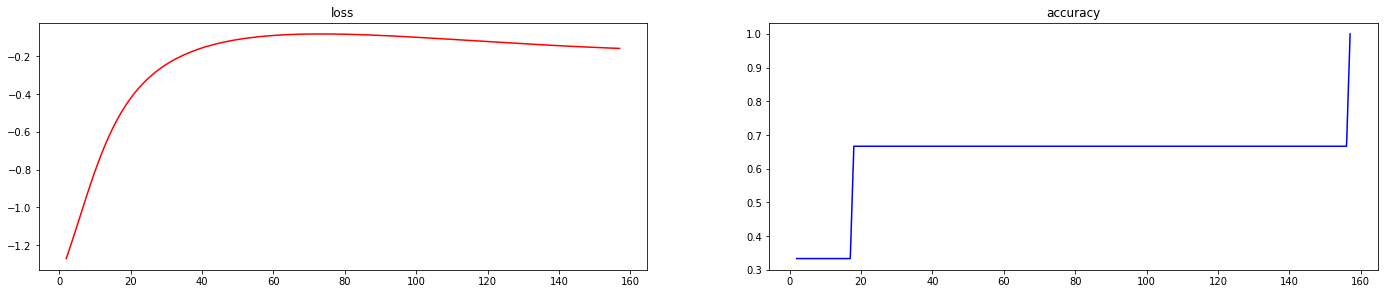

In [91]:
#XOR PROBLEM
dataset = np.array([[1,1], [0,1],[0,0]])
targets = np.array([[0,1,0]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
#nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

#fit and predict
nn.fit(dataset, targets, 0.25, batch_size=2, train_ratio=1.0, epochs=1000)
nn.predict(np.array([[1,1], [1,0], [0,1], [0,0]]))

break at epoch  285
[-0.20886279]   1.0
elapsed: 
 0.10435199737548828  ms


array([[0.50403617],
       [0.32909688],
       [0.32046934]])

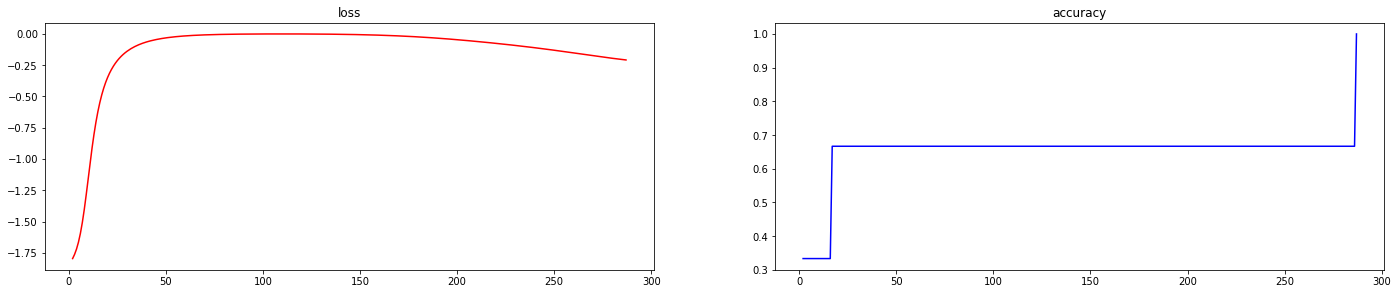

In [88]:
#AND PROBLEM WITH 3 VAR
dataset = np.array([[1,1,0],[1,1,1],[0,0,1]])
targets = np.array([[0,1,0]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 4, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

#fit and predict
nn.fit(dataset, targets, 0.25, epochs= 5000)
nn.predict(np.array([[1,1,1], [0,1,0], [0,0,0]]))

In [94]:
#??
dataset = np.array([[0,1,0],[0,0,1],[1,0,0],[1,1,0],[1,1,1]])
targets = np.array([[1,0,0,1,1]])

#the neural network
nn = NeuralNetwork()
nn.add_layer('dense', 1, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 2, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

nn.fit(dataset, targets, 0.25, 400)

ValueError: number sections must be larger than 0.

In [214]:
#MONK1 PROBLEM

train_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks1-train.txt", delimiter=" ", dtype="int")[:,1:-1] #rimuove la colonna nan alla fine
train_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks1-train.txt", delimiter=" ", dtype="int")[:,0:1].T

test_set = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks1-test.txt", delimiter=" ", dtype="int") [:,1:-1] #rimuove targets e colonna nan 
test_targets = np.genfromtxt("/home/remo/anaconda3/notebooks/ML/monks1-test.txt", delimiter=" ", dtype="int") [:,0:1].T

tr - loss  [-1.0798676]  accuracy  0.797979797979798
vl - loss  [-3.97470085]  accuracy  0.84
elapsed: 
 0.25891780853271484  ms


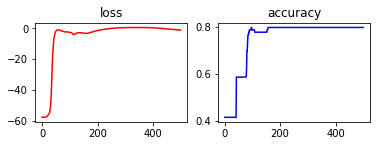

In [243]:
nn = NeuralNetwork()
nn.add_layer('dense', 10, 'sigmoid', train_set.shape[1]) #input layer
nn.add_layer('dense', 10, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')

nn.fit(train_set, train_targets, 0.01, 0.8, 500, 1000) #0.1 0.01 1 10

In [246]:
#l,a = nn.evaluate(test_set, test_targets)
#print(a)
res = nn.predict(test_set).T
#rounded = np.around(res)
p = np.around(test_targets - res)
accuracy = (p.size - np.count_nonzero(p))/p.size
print(p.size, np.count_nonzero(p), accuracy)
print(accuracy)

432 107 0.7523148148148148
0.7523148148148148


break at epoch  26
elapsed: 
 0.12863659858703613  ms


(array([-1.02698608]), 0.8)

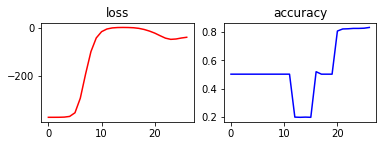

In [211]:
dataset, targets = make_moons(n_samples=1000)
targets=targets.reshape(1, targets.size)

nn = NeuralNetwork()
nn.add_layer('dense', 5, 'sigmoid', dataset.shape[1]) #input layer
nn.add_layer('dense', 20, 'sigmoid')
nn.add_layer('dense', 10, 'sigmoid')
nn.add_layer('dense', 1, 'sigmoid')
#lr = 0.1 or o.2 with 1000 sample = disaster
#with 0,01 is okay
nn.fit(dataset, targets, 0.01, 0.75, 30, 20) #0.1 0.01 1 10

test_set, test_targets = make_moons(n_samples=20)
test_targets=test_targets.reshape(1, test_targets.size)

nn.evaluate(test_set, test_targets.T)